In [ ]:
import csv
import math
import os
import cv2

from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, DepthwiseConv2D, ZeroPadding2D, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend as K
DATA_DIR = "images"

# 0.35, 0.5, 0.75, 1.0, 1.3, 1.4
ALPHA = 0.75

# 96, 128, 160, 192, 224
IMAGE_SIZE = 224

EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20

data = pd.read_csv('training.csv')
train, test = train_test_split(data, test_size=0.1, random_state=123)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train.to_csv('train.csv', index=False)
test.to_csv('validation.csv', index=False)

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

In [2]:
df = pd.read_csv('validation.csv')

In [19]:
df.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160624_135055_1000527160000.png,132,606,165,325
1,147771890839520161028_141911.png,123,544,52,452
2,1474715198275DSC07675.png,311,458,32,459
3,JPEG_20161117_112207_1000880661419.png,13,640,5,459
4,147444941744811473248953580-Roadster-Men-Navy-...,34,603,16,471


In [3]:
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

In [4]:
val_coords = np.zeros((len(df),4))
val_images = np.zeros((len(df), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

In [5]:
for index, row in df.iterrows():
    path = os.path.join(DATA_DIR, row['image_name'])
    x1 = row['x1']
    x2 = row['x2']
    y1 = row['y1']
    y2 = row['y2']

    img = Image.open(path)
    width, height = img.size

    val_coords[index, 0] = x1*IMAGE_SIZE / width
    val_coords[index, 1] = y1*IMAGE_SIZE / height
    val_coords[index, 2] = (x2 - x1)* IMAGE_SIZE / width
    val_coords[index, 3] = (y2 - y1)*IMAGE_SIZE / height 
    
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    pil_img = img
    img = np.array(img, dtype=np.float32)
    val_images[index] = preprocess_input(img.copy())
    pil_img.close()


In [21]:

class DataGenerator(Sequence):

    def __init__(self, csv_file,rnd_rescale=True, rnd_multiply=True, rnd_color=True, rnd_crop=True, rnd_flip=True,
                 batch_size = BATCH_SIZE):
        self.paths = []
        self.coords = []
        self.batch_size = batch_size
        self.rnd_rescale = rnd_rescale
        self.rnd_multiply = rnd_multiply
        self.rnd_color = rnd_color
        self.rnd_crop = rnd_crop
        self.rnd_flip = rnd_flip

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file)-1, 4))
            
        df = pd.read_csv(csv_file)

        for index, row in df.iterrows():
            path = os.path.join(DATA_DIR, row['image_name'])
            x1 = row['x1']
            x2 = row['x2']
            y1 = row['y1']
            y2 = row['y2']

            img = Image.open(path)
            width, height = img.size

            self.coords[index, 0] = x1
            self.coords[index, 1] = y1
            self.coords[index, 2] = x2 
            self.coords[index, 3] = y2 

            self.paths.append(path)
        
#         print(len(self.paths))
#         print(len(self.coords))


    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size//2:(idx + 1) * self.batch_size//2]
        coords = self.coords[idx * self.batch_size//2:(idx + 1) * self.batch_size//2].copy()
        batch_coords = np.zeros((self.batch_size,4))
        batch_images = np.zeros((self.batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            x0,y0,x1,y1 = coords[i]
            img2 = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img2 = img.convert('RGB')
            img2 = np.array(img2, dtype=np.float32)
            batch_images[i] = preprocess_input(img2.copy())
            
            batch_coords[i, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height 

            if self.rnd_rescale:
                old_width = img.width
                old_height = img.height

                rescale = np.random.uniform(low=0.6, high=1.4)
                new_width = int(old_width * rescale)
                new_height = int(old_height * rescale)

                img = img.resize((new_width, new_height))

                x0 *= new_width / old_width
                y0 *= new_height / old_height
                x1 *= new_width / old_width
                y1 *= new_height / old_height

            if self.rnd_crop:
                start_x = np.random.randint(0, high=np.floor(0.15 * img.width))
                stop_x = img.width - np.random.randint(0, high=np.floor(0.15 * img.width))
                start_y = np.random.randint(0, high=np.floor(0.15 * img.height))
                stop_y = img.height - np.random.randint(0, high=np.floor(0.15 * img.height))

                img = img.crop((start_x, start_y, stop_x, stop_y))

                x0 = max(x0 - start_x, 0)
                y0 = max(y0 - start_y, 0)
                x1 = min(x1 - start_x, img.width)
                y1 = min(y1 - start_y, img.height)

                if np.abs(x1 - x0) < 5 or np.abs(y1 - y0) < 5:
                    print("\nWarning: cropped too much (obj width {}, obj height {}, img width {}, img height {})\n".format(x1 - x0, y1 - y0, img.width, img.height))

            if self.rnd_flip:
                elem = np.random.choice([0, 90, 180, 270, 1423, 1234])
                if elem % 10 == 0:
                    x = x0 - img.width / 2
                    y = y0 - img.height / 2

                    x0 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y0 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    x = x1 - img.width / 2
                    y = y1 - img.height / 2

                    x1 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y1 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    img = img.rotate(-elem)
                else:
                    if elem == 1423:
                        img = img.transpose(Image.FLIP_TOP_BOTTOM)
                        y0 = img.height - y0
                        y1 = img.height - y1

                    elif elem == 1234:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                        x0 = img.width - x0
                        x1 = img.width - x1

            image_width = img.width
            image_height = img.height

            tmp = x0
            x0 = min(x0, x1)
            x1 = max(tmp, x1)

            tmp = y0
            y0 = min(y0, y1)
            y1 = max(tmp, y1)

            x0 = max(x0, 0)
            y0 = max(y0, 0)

            y0 = min(y0, image_height)
            x0 = min(x0, image_width)
            y1 = min(y1, image_height)
            x1 = min(x1, image_width)

            if self.rnd_color:
                enhancer = ImageEnhance.Color(img)
                img = enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

                enhancer2 = ImageEnhance.Brightness(img)
                img = enhancer.enhance(np.random.uniform(low=0.7, high=1.3))

            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')
            pil_img = img
            img = np.array(img, dtype=np.float32)
            pil_img.close()
            if self.rnd_multiply:
                img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))

            batch_images[i+1] = preprocess_input(img.copy())
            
            batch_coords[i+1, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i+1, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i+1, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i+1, 3] = (y1 - y0) * IMAGE_SIZE / image_height 

        return batch_images, batch_coords

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

def create_model(trainable=False):
    model = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet',pooling = 'avg')

    # to freeze layers
    for layer in model.layers:
        layer.trainable = True

    x = model.layers[-1].output
    #x = Conv2D(256, kernel_size=3, name="coords1", activation='relu')(x)
    x = Dense(4, name="coords2", activation='relu')(x)
    x = Reshape((4,))(x)

    return Model(inputs=model.input, outputs=x)



In [9]:
import tensorflow as tf

In [10]:
ts = tf.zeros((2,3))

In [13]:
def IOU(y_true, y_pred):
    diff_width = K.minimum(y_true[:,0] + y_true[:,2], y_pred[:,0] + y_pred[:,2]) - K.maximum(y_true[:,0], y_pred[:,0])
    diff_height = K.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3]) - K.maximum(y_true[:,1], y_pred[:,1])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = K.maximum(area_gt + area_pred - intersection, 0)

    #ntersection = K.sum(intersection * (union > 0))
    intersection = K.tf.where(union > 0, intersection, K.zeros_like(intersection))
    intersection = K.sum(intersection)
    union = K.sum(union)
    iou = (intersection / (union + epsilon()))
    return iou

In [14]:
class ValDataGenerator(Sequence):
    def __init__(self, csv_file, val_images, val_coords, batch_size = BATCH_SIZE):
        self.images = val_images
        self.coords = val_coords
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_images, batch_coords

In [15]:
val_datagen = ValDataGenerator(VALIDATION_CSV, val_images,val_coords)

In [16]:
imgs, coords = (val_datagen).__getitem__(10)

In [17]:
coords[2]

array([ 21.        ,   0.        , 139.3       , 193.66666667])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


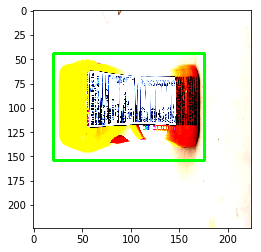

In [18]:
img = imgs[3]
x0,y0,x1,y1 = coords[3]
x1 = x0 + x1
y1 = y0 + y1
cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)),(0, 255, 0), 2)
plt.imshow(img)

In [52]:
x1

176.75

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


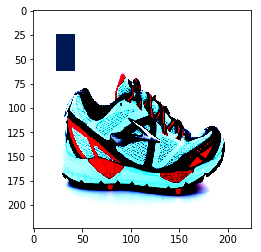

In [53]:
plt.imshow(imgs[0])

In [31]:

# class DataGenerator(Sequence):

#     def __init__(self, csv_file, batch_size = BATCH_SIZE, enable_aug = False):
#         self.paths = []
#         self.coords = []
#         self.batch_size = batch_size
#         self.enable_aug = enable_aug

#         with open(csv_file, "r") as file:
#             self.coords = np.zeros((sum(1 for line in file)-1, 4))
            
#         df = pd.read_csv(csv_file)

#         for index, row in df.iterrows():
#             path = os.path.join(DATA_DIR, row['image_name'])
#             x1 = row['x1']
#             x2 = row['x2']
#             y1 = row['y1']
#             y2 = row['y2']

#             img = Image.open(path)
#             width, height = img.size

#             self.coords[index, 0] = x1 * IMAGE_SIZE / width
#             self.coords[index, 1] = y1 * IMAGE_SIZE / height
#             self.coords[index, 2] = (x2 - x1) * IMAGE_SIZE / width
#             self.coords[index, 3] = (y2 - y1) * IMAGE_SIZE / height 

#             self.paths.append(path)


#     def __len__(self):
#         return math.ceil(len(self.coords) / self.batch_size)

#     def __getitem__(self, idx):
#         batch_paths = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_coords_hflip = np.zeros((len(batch_coords),4))
#         batch_coords_vflip = np.zeros((len(batch_coords),4))
#         batch_coords_rotate90 = np.zeros((len(batch_coords),4))

#         batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#         batch_images_hflip = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#         batch_images_vflip = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#         batch_images_rotate90 = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

#         for i, f in enumerate(batch_paths):
#             img = Image.open(f)
#             img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#             img = img.convert('RGB')
#             batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            
#             if self.enable_aug!=True:
#                 img.close()
#                 continue
            
#             img = img.transpose(Image.FLIP_LEFT_RIGHT)
#             batch_images_hflip[i] = preprocess_input(np.array(img, dtype=np.float32))
            
#             img = img.transpose(Image.FLIP_LEFT_RIGHT)
#             img = img.transpose(Image.FLIP_TOP_BOTTOM)
#             batch_images_vflip[i] = preprocess_input(np.array(img, dtype=np.float32))
            
#             img = img.transpose(Image.FLIP_TOP_BOTTOM)
#             img = img.transpose(Image.ROTATE_90)
#             batch_images_rotate90[i] = preprocess_input(np.array(img, dtype=np.float32))
            
#             x1, y1, w, h = batch_coords[i]
#             x1 += 2*(IMAGE_SIZE/2 - x1)
#             x1 = int(x1 - w)
#             batch_coords_hflip[i, 0] = x1
#             batch_coords_hflip[i, 1] = y1
#             batch_coords_hflip[i, 2] = w
#             batch_coords_hflip[i, 3] = h
            
#             x1, y1, w, h = batch_coords[i]
#             y1 += 2*(IMAGE_SIZE/2 - y1)
#             y1 = int(y1 - h)
#             batch_coords_vflip[i, 0] = x1
#             batch_coords_vflip[i, 1] = y1
#             batch_coords_vflip[i, 2] = w
#             batch_coords_vflip[i, 3] = h
            
#             x1, y1, w, h = batch_coords[i]
#             tx1 = x1
#             x1 = y1
#             y1 = IMAGE_SIZE - (tx1+w)
#             temp = w
#             w = h
#             h = temp
#             batch_coords_rotate90[i, 0] = x1
#             batch_coords_rotate90[i, 1] = y1
#             batch_coords_rotate90[i, 2] = w
#             batch_coords_rotate90[i, 3] = h
            
#             img.close()
        
#         if self.enable_aug!=True:
#             return batch_images, batch_coords
            
#         return np.concatenate((batch_images, batch_images_hflip, batch_images_vflip, batch_images_rotate90)), np.concatenate((batch_coords, batch_coords_hflip, batch_coords_vflip, batch_coords_rotate90))


In [22]:
model = create_model()
# model.summary()
train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = Validation(generator=ValDataGenerator(VALIDATION_CSV, val_images, val_coords))


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [25]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy',IOU])

checkpoint = ModelCheckpoint("densenet_gap_pretrained-data_aug-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

# model.summary()

In [26]:
!nvidia-smi

Fri Feb  8 17:51:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    38W / 300W |  15349MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [ ]:
model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[validation_datagen, reduce_lr, stop, checkpoint],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)


Epoch 1/500
 32/394 [=>............................] - ETA: 9:06 - loss: 12591.7073 - acc: 0.6335 - IOU: 0.0019

102/394 [======>.......................] - ETA: 2:57 - loss: 9143.2179 - acc: 0.7597 - IOU: 0.0471

393/394 [============================>.] - ETA: 0s - loss: 3160.1968 - acc: 0.8492 - IOU: 0.4582 - val_iou: 0.6876 - val_mse: 353.8115

Epoch 00001: val_iou improved from -inf to 0.68760, saving model to densenet_gap_pretrained-data_aug-0.69.h5
394/394 [==============================] - 260s 660ms/step - loss: 3153.2102 - acc: 0.8495 - IOU: 0.4589
Epoch 2/500
 42/394 [==>...........................] - ETA: 1:07 - loss: 380.0110 - acc: 0.8921 - IOU: 0.7433

232/394 [================>.............] - ETA: 31s - loss: 351.2096 - acc: 0.8968 - IOU: 0.7551

393/394 [============================>.] - ETA: 0s - loss: 336.6962 - acc: 0.9046 - IOU: 0.7661 - val_iou: 0.7303000000000001 - val_mse: 307.5031

Epoch 00002: val_iou improved from 0.68760 to 0.73030, saving model to densenet_g

In [60]:
sample = pd.read_csv("train.csv")
sample.head()

,image_name,x1,x2,y1,y2
0,1474724014247DSC07926.png,258,424,96,381
1,JPEG_20160623_170956_1000885486700.png,293,583,134,359
2,147185868090020160818_111244.png,112,478,2,452
3,JPEG_20160513_115642_1000775593523.png,83,589,168,398
4,JPEG_20161118_133812_1000159834754.png,172,519,0,480


In [35]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.mobilenetv2 import preprocess_input

WEIGHTS_FILE = "densenet_no_wts-data_aug-0.91.h5"
IMAGES = "images/*png"

# model = create_model()
model.load_weights(WEIGHTS_FILE)


Using TensorFlow backend.


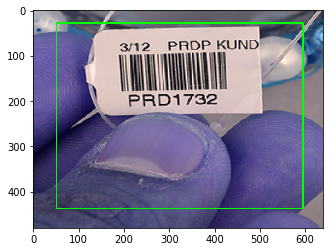

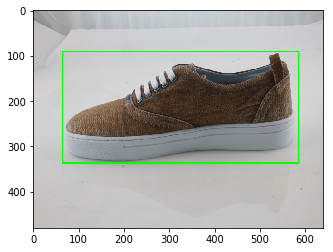

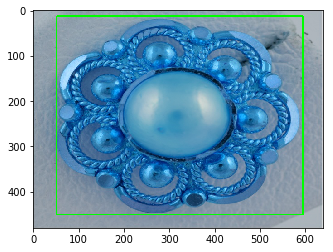

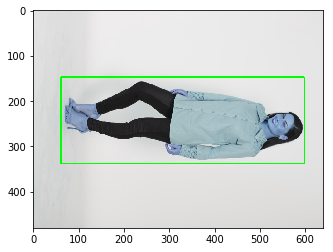

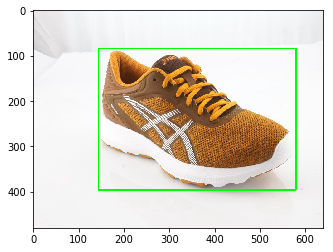

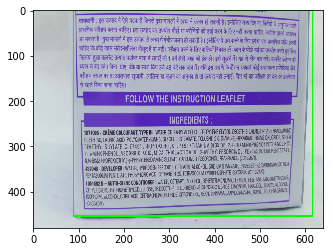

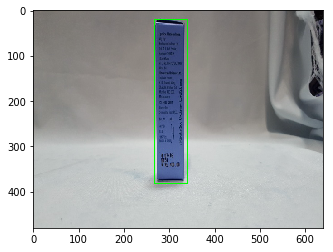

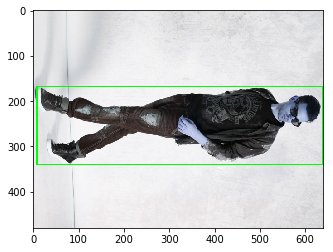

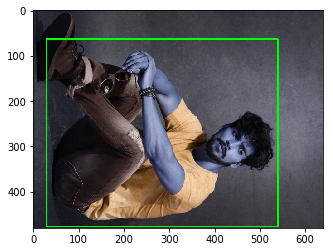

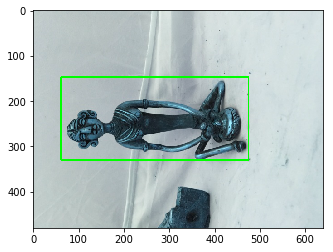

In [71]:

for filename in glob.glob(IMAGES)[8000:8010]:
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x0 = int(region[0] * image_width / IMAGE_SIZE)
    y0 = int(region[1] * image_height / IMAGE_SIZE)

    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 255, 0), 2)
    plt.imshow(unscaled)
    plt.show()

In [42]:
sample = pd.read_csv("validation.csv")
sample.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160624_135055_1000527160000.png,132,606,165,325
1,147771890839520161028_141911.png,123,544,52,452
2,1474715198275DSC07675.png,311,458,32,459
3,JPEG_20161117_112207_1000880661419.png,13,640,5,459
4,147444941744811473248953580-Roadster-Men-Navy-...,34,603,16,471


In [43]:
for index, row in sample.iterrows():
    unscaled = cv2.imread('images/'+row['image_name'])
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x1 = int(region[0] * image_width / IMAGE_SIZE)
    y1 = int(region[1] * image_height / IMAGE_SIZE)

    x2 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y2 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

    sample.iloc[index,1] = x1
    sample.iloc[index,2] = x2
    sample.iloc[index,3] = y1
    sample.iloc[index,4] = y2

sample.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160624_135055_1000527160000.png,137,601,171,322
1,147771890839520161028_141911.png,121,552,44,461
2,1474715198275DSC07675.png,304,456,25,467
3,JPEG_20161117_112207_1000880661419.png,113,628,46,463
4,147444941744811473248953580-Roadster-Men-Navy-...,37,603,23,477


In [44]:
sample.to_csv('valid_pred_densenet121.csv', index=False)